# Install packages

In [1]:
# ! pip install segmentation_models_pytorch
# ! pip install pytorch_lightning==1.9.2
# ! pip install torchvision
# ! pip install albumentations
# !pip install tabulate

# https://www.kaggle.com/code/santurini/multi-class-segmentation-pytorch-lightning

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import random
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from pprint import pprint
from random import randint


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
import random

import os
from tqdm import tqdm
from collections import OrderedDict


import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from tabulate import tabulate


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Prepare dataset

In [4]:

def masks_multiclass(path_img, path_mask):
    size = (224,224)
    classes = {
        "1. Microaneurysms": "_MA",
        "2. Haemorrhages": "_HE",
        "3. Hard Exudates": "_EX",
        "4. Soft Exudates": "_SE",
        "5. Optic Disc": "_OD"
    }

    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)

        
    img_name = path_img.split('/')[-1][:-4]

    AnnMap = np.zeros(img.shape[0:2],np.float32) # Segmentation map 

    for label in os.listdir(path_mask):
        mask = cv2.imread(path_mask + label + '/' + img_name + classes[label] + '.tif')
        
        if mask is not None:
            mask = cv2.resize(mask, size)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

            if label == '1. Microaneurysms':  AnnMap[mask == np.max(mask)] = 1
            if label == '2. Haemorrhages':  AnnMap[ mask  == np.max(mask)] = 2
            if label == '3. Hard Exudates':  AnnMap[ mask  == np.max(mask)] = 3
            if label == '4. Soft Exudates':  AnnMap[ mask  == np.max(mask)] = 4
            if label == '5. Optic Disc':  AnnMap[ mask  == np.max(mask)] =  5        
        
    return img, AnnMap

In [41]:
#function for save and load in python/json objects the dictionaries
def save_pickle(dic, path):
    with open(f"{path}", 'wb') as f:
        pickle.dump(dic, f, pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(f"{path}", 'rb',) as f:
        return pickle.load(f)

# create a dataframe with id of the images without extensions (.jpg)
def create_df(IMAGE_PATH):
    name = []
    mask = []
    for dirname, _, filenames in os.walk(IMAGE_PATH): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)

In [42]:
# train
IMAGE_PATH = "C:/Users/debora.assis/Documents/Ermeson_UNet-SegRD/datasets/train/images/"
MASK_PATH = "C:/Users/debora.assis/Documents/Ermeson_UNet-SegRD/datasets/train/masks/"


# test
IMAGE_PATH_TEST = "C:/Users/debora.assis/Documents/Ermeson_UNet-SegRD/datasets/test/images/"
MASK_PATH_TEST = "C:/Users/debora.assis/Documents/Ermeson_UNet-SegRD/datasets/test/masks/"


# Valid


X = create_df(IMAGE_PATH)['id'].values
X_test = create_df(IMAGE_PATH_TEST)['id'].values

# Train Test Split
X_train, X_val = train_test_split(X, test_size=0.20, random_state=123)

print('Train Size   : ', len(X_train)) # lista com nome das imagens
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  43
Val Size     :  11
Test Size    :  27


# Data augmentation

In [7]:

data_transforms = {
    'train': A.Compose([
                A.Resize(224, 224),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5),
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224), 
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2()
    ]),
}


In [8]:

class GlaucomaSegmentationDataset(Dataset):
    def __init__(self, paths_image, paths_mask, X, transform=None, target_transform=None):
        self.paths_image = paths_image
        self.paths_mask = paths_mask
        self.X = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image, mask = masks_multiclass(self.paths_image + self.X[idx] + '.jpg', self.paths_mask)

        mask = np.expand_dims(mask, 2)
    
        
        if self.transform:  
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = mask.permute(2,0,1)
            
        # if self.target_transform:
        #     label = self.target_transform(label)
        return {'image':image, 'mask':mask}
    
Glaucoma_dataset = GlaucomaSegmentationDataset(IMAGE_PATH, MASK_PATH, X_train, data_transforms['train'])
Glaucoma_dataloader = DataLoader(Glaucoma_dataset, batch_size=4, shuffle=True)

In [9]:
import numpy as np
batch = next(iter(Glaucoma_dataloader))
inputs = batch['image']
inputs.size()

torch.Size([4, 3, 224, 224])

In [10]:
m = batch['mask']
np.unique(m)

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [11]:
m.size()

torch.Size([4, 1, 224, 224])

# Visualization

torch.Size([3, 228, 906])
torch.Size([3, 228, 906])


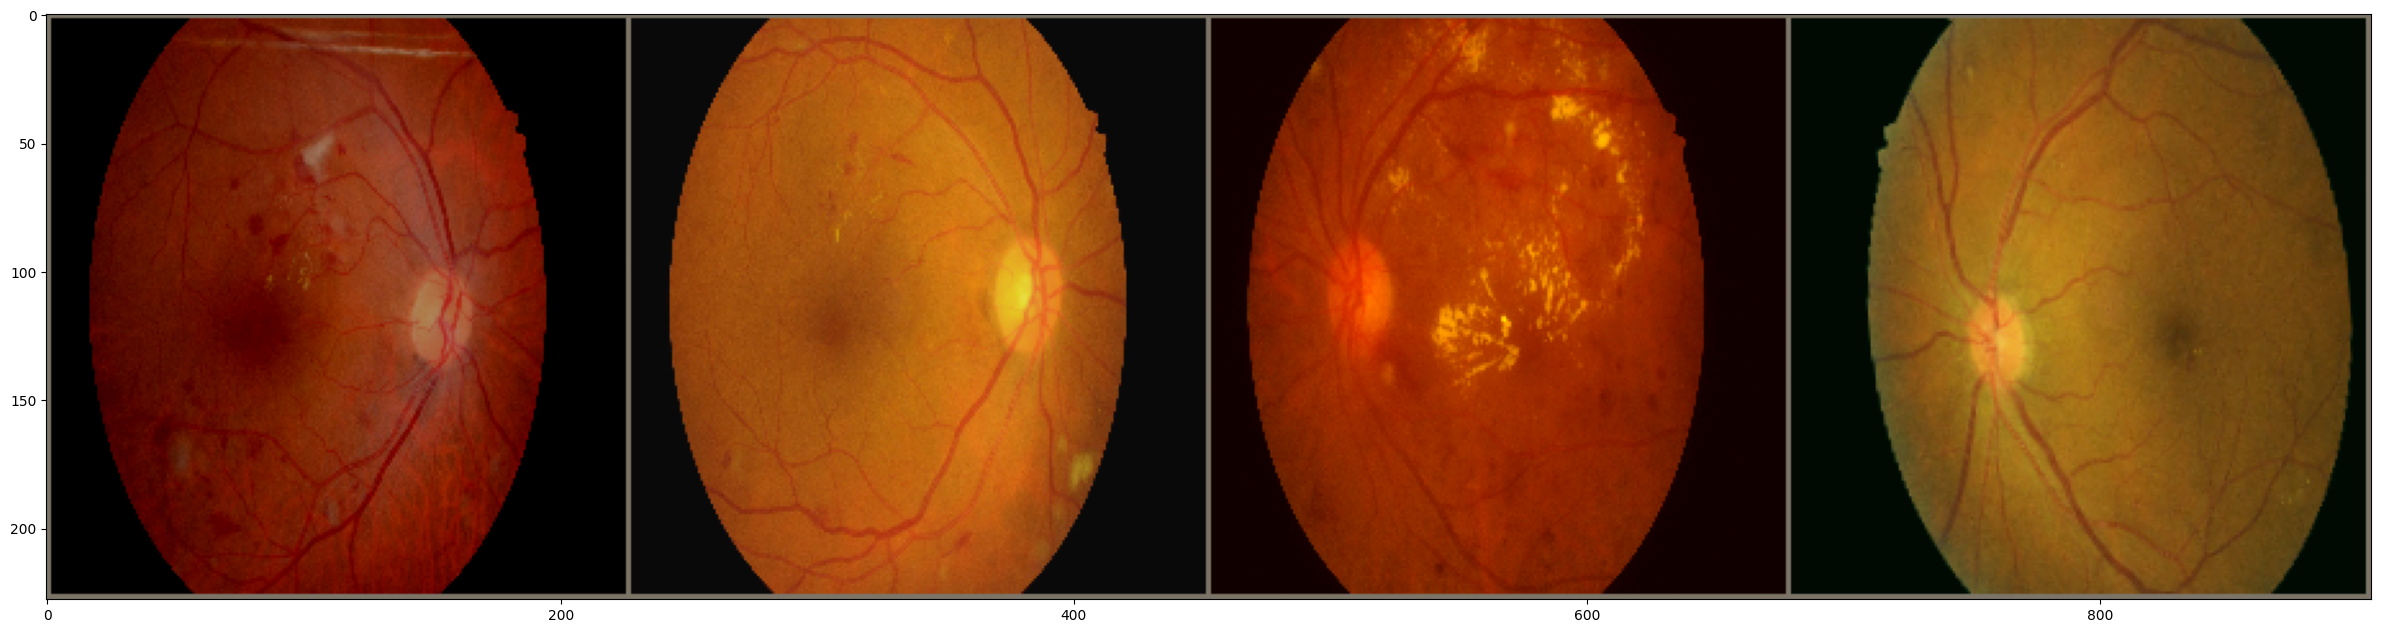

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 228, 906])
[0. 1. 2. 3. 4. 5.]


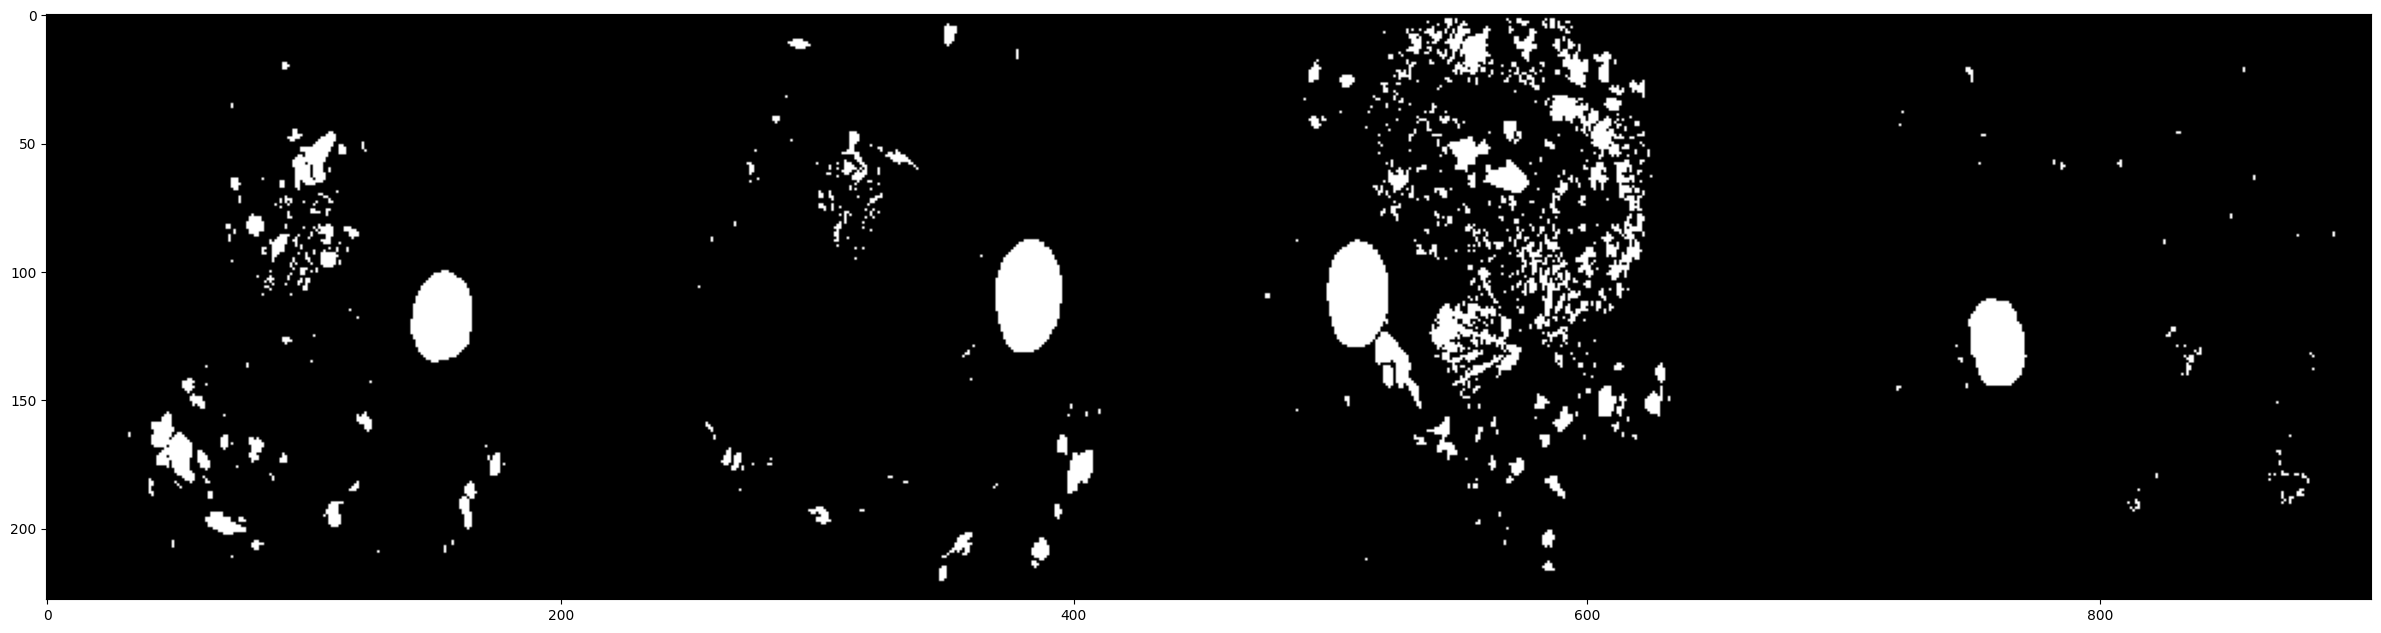

In [12]:
import torchvision
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [30, 20]

def imshow_img(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def imshow_mask(inp, title=None):
    """Imshow for Tensor."""
    print(inp.size())
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    print(np.unique(inp))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
batch = next(iter(Glaucoma_dataloader))
inputs = batch['image']
masks = batch['mask']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
out2 = torchvision.utils.make_grid(masks)
print(out.shape)
print(out2.shape)

imshow_img(out)
imshow_mask(out2)

# Train U-Net

In [13]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

class GlaucomaModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, loss_name, lr, beta,  **kwargs):
        super().__init__()
        
        self.model = smp.create_model(
                    arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
                    )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        
        self.lr = lr
        
        # for image segmentation dice loss could be the best first choice
        
        if loss_name == 'Dice':
            self.loss_fn =smp.losses.DiceLoss(mode='multiclass', from_logits=True)
#         if loss_name == 'Tversky':
#             self.loss_fn = smp.losses.TverskyLoss(smp.losses.BINARY_MODE, from_logits=True, beta=beta)
#         if loss_name == 'Lovasz':
#             self.loss_fn = smp.losses.LovaszLoss(smp.losses.BINARY_MODE, from_logits=True)
        
        self.save_hyperparameters()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        mask = batch["mask"]
        assert mask.ndim == 4

        assert mask.max() <= 5.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        
        loss = self.loss_fn(logits_mask, mask.long())

        
        ground_truth_onehot = torch.zeros_like(pred_mask) 
        ground_truth_onehot.scatter_(1, mask.long(), 1)

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), ground_truth_onehot.long(), mode='multiclass', num_classes = 5)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
 
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        loss = outputs[0]["loss"]

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro-imagewise")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro-imagewise")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_loss": loss,
            
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Trainer

In [43]:
train_dataset = GlaucomaSegmentationDataset(IMAGE_PATH, MASK_PATH, X_train, data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

val_dataset = GlaucomaSegmentationDataset(IMAGE_PATH, MASK_PATH, X_val, data_transforms['val'])
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

test_dataset = GlaucomaSegmentationDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [15]:
seg_encoder = 'mobilenet_v2' # https://github.com/qubvel/segmentation_models.pytorch
seg_model = 'UnetPlusPlus' #  Unet, UnetPlusPlus, MAnet, Linknet, FPN, PSPNet, PAN, DeepLabV3,DeepLabV3Plus


checkpoint_callback = ModelCheckpoint(
      dirpath='/weights',
      filename=f'seg_Unetpp_Mobilev2',
      monitor='valid_dataset_iou',
      mode="max",
    )


early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    patience=35, 
    verbose=False, 
    mode="min"
    )


model = GlaucomaModel(seg_model, seg_encoder, in_channels=3, lr=0.001, loss_name='Dice', beta=None, out_classes=6)

trainer = pl.Trainer(
#     gpus=1, 
    max_epochs=40,
    callbacks = [checkpoint_callback, early_stop_callback],
#     accumulate_grad_batches=2
    #logger=wandb_logger,
    #auto_lr_find=True,
)

trainer.fit(
    model, train_dataloader, 
    val_dataloaders=val_dataloader,
)
      


# run validation dataset
# valid_metrics = trainer.validate(model=model, dataloaders=val_dataloaders)
# pprint(valid_metrics)

# run test dataset
test_metrics = trainer.test(model, test_dataloader, verbose=False)
pprint(test_metrics)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\debora.assis\Anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 6.8 M 
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.302    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\debora.assis\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\debora.assis\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\debora.assis\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_eve

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
C:\Users\debora.assis\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{'test_accuracy': 0.9976788759231567,
  'test_dataset_iou': 0.9918405413627625,
  'test_f1_score': 0.9958451986312866,
  'test_loss': 0.43643665313720703,
  'test_per_image_iou': 0.9918405413627625}]


# Testing

In [16]:
# Saving a checkpoint
# torch.save(model.state_dict(), 'model_Unetpp_Mobilev2_teste.pth')

# model.load_state_dict(torch.load('model_Unetpp_Mobilev2_teste.pth'))

test_metrics = trainer.test(model, test_dataloader, verbose=False)
pprint(test_metrics)

Testing: 0it [00:00, ?it/s]

[{'test_accuracy': 0.9976788759231567,
  'test_dataset_iou': 0.9918405413627625,
  'test_f1_score': 0.9958451986312866,
  'test_loss': 0.43643665313720703,
  'test_per_image_iou': 0.9918405413627625}]


# test evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


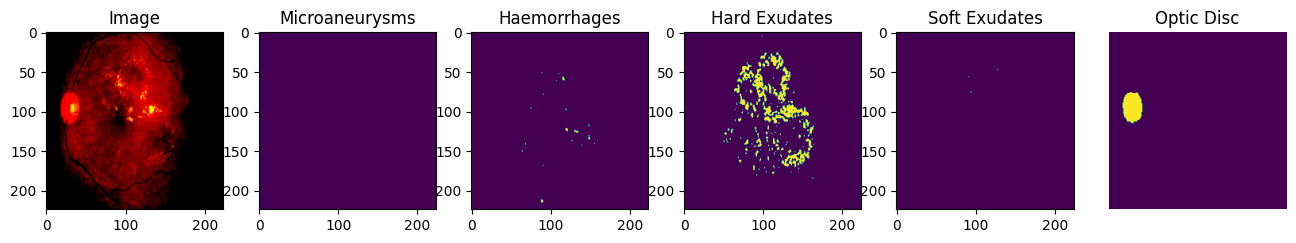

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


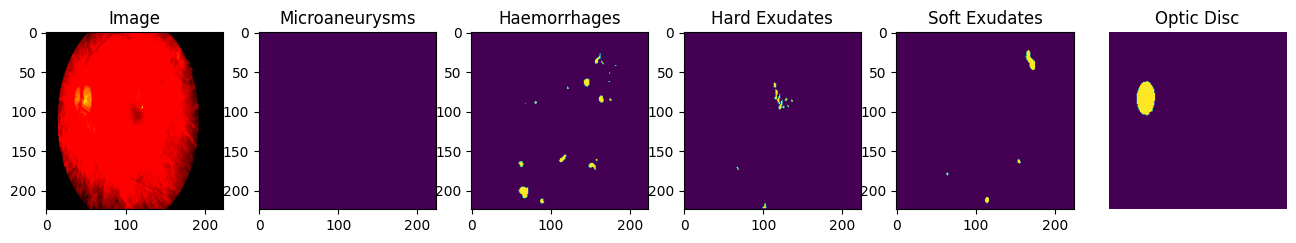

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


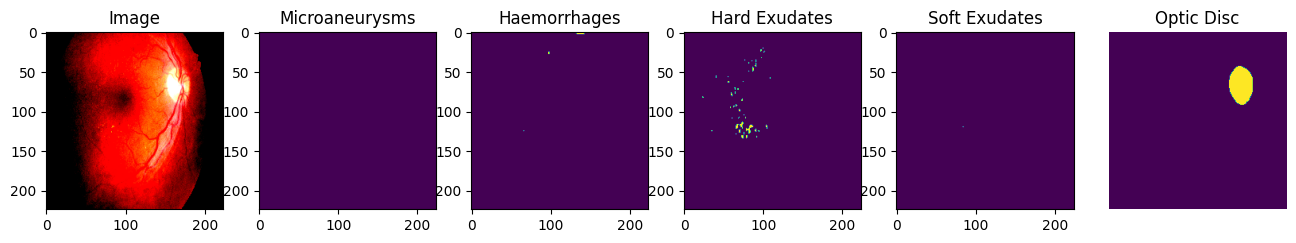

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


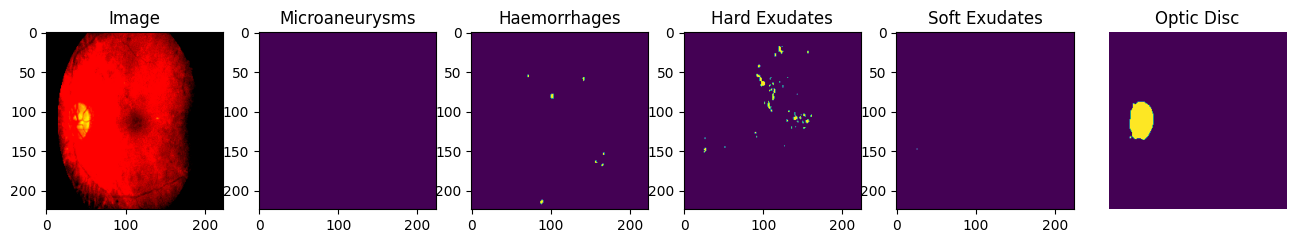

In [44]:
num_classes = 5


batch = next(iter(test_dataloader))
images = batch['image']
mask = batch['mask']

with torch.no_grad():
    model.eval()
    prediction = model(images) # imagem binária para cada classe [batches, classes, h, w]
    prediction_mask = torch.argmax(prediction, 1) # imagem de 0 a N° classes em uma imagem [batches, h, w]
    prob_mask = prediction.sigmoid()
    pred_mask = (prob_mask > 0.5).float()

    
for image, pr_mask in zip(batch["image"], pred_mask):
    
    pr_mask = pr_mask.numpy()

    plt.figure(figsize=(16, 16))
    title = ['Image', "Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"]
    plt.subplot(1, 6, 1)
    plt.title(title[0])
    plt.imshow(np.array(image).transpose(1,2,0))
    
    plt.subplot(1, 6, 2)
    plt.title(title[1])
    plt.imshow(pr_mask[1])
    
    plt.subplot(1, 6, 3)
    plt.title(title[2])
    plt.imshow(pr_mask[2])
    
    plt.subplot(1, 6, 4)
    plt.title(title[3])
    plt.imshow(pr_mask[3])
    
    plt.subplot(1, 6, 5)
    plt.title(title[4])
    plt.imshow(pr_mask[4])
    
    plt.subplot(1, 6, 6)
    plt.title(title[5])
    plt.imshow(pr_mask[5])
    plt.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


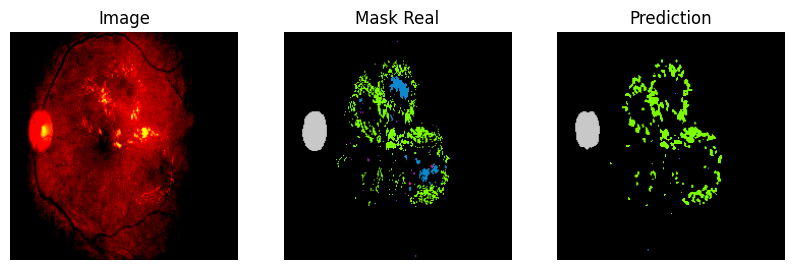

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


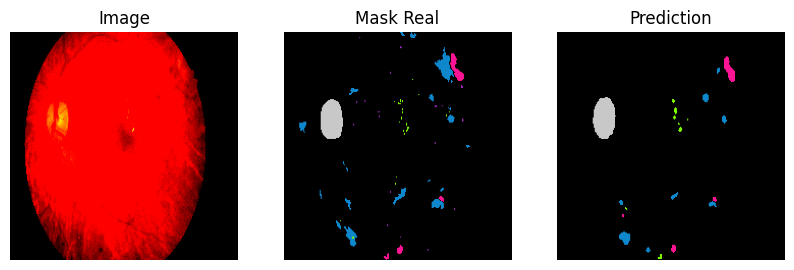

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


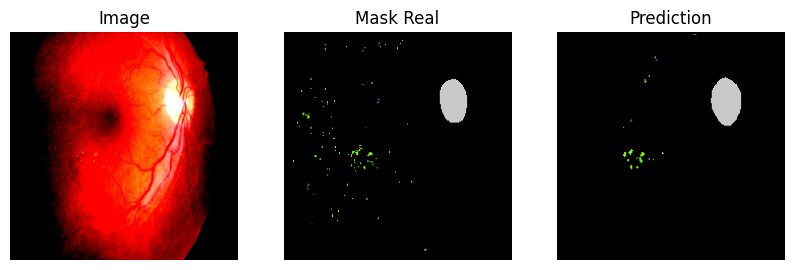

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


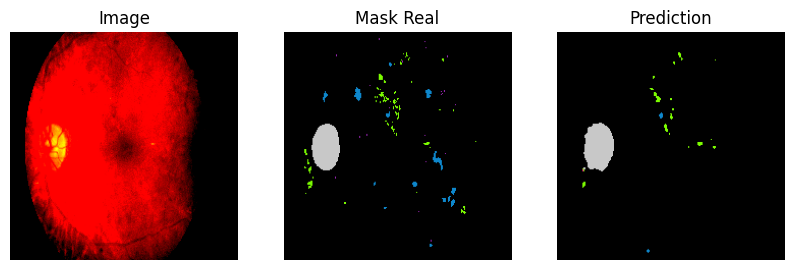

In [45]:

def color_mask(pred_mask):
    merged_mask = torch.zeros_like(pred_mask)

    for class_idx in range(1,6): 
        mask = pred_mask == class_idx
        merged_mask[mask] = class_idx

    merged_mask_np = merged_mask.squeeze().cpu().numpy()

    # Create a color palette for the mask
    palette = [
        0, 0, 0,  # Background (class 0)
        155, 38, 182,  # Class 1 color
        14, 135, 204,  # Class 2 color
        124, 252, 0,  # Class 3 color
        255, 20, 147,  # Class 4 color
        200, 200, 200  # Class 5 color
    ]

    # Convert the merged mask numpy array to a PIL image
    merged_mask_pil = Image.fromarray(merged_mask_np.astype(np.uint8))

    # Create a new image with the color palette
    merged_mask_pil = merged_mask_pil.convert('P')
    merged_mask_pil.putpalette(palette)

    return merged_mask_pil


for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], prediction_mask):
    
    mask_predict = color_mask(pr_mask)
    mask_true = color_mask(gt_mask)
        
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_true) # just squeeze classes dim, because we have only one class
    plt.title("Mask Real")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_predict) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [46]:
batch = next(iter(test_dataloader))
images = batch['image']
mask = batch['mask']
outputs = []
test_loss = 0.0
iou = 0

        
with torch.no_grad():
    model.eval()
    prediction = model(images) # imagem binária para cada classe [batches, classes, h, w]
    prediction_mask = torch.argmax(prediction, 1) # imagem de 0 a N° classes em uma imagem [batches, h, w]
    prob_mask = prediction.sigmoid()
    pred_mask = (prob_mask > 0.5).float()
    

    tp, fp, fn, tn = smp.metrics.get_stats(prediction_mask.long().unsqueeze(1), mask.long(), mode='multiclass', num_classes = 5)
    outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
    criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    loss = criterion(prediction, mask.long()) 
    test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

Test Loss: 0.05870388235364642
IoU: 0.9653896689414978


In [47]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_negative_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0)]).numpy(), 3)

#  "Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"
    
info = {'Metrics': ['Recall', 'FPR', 'FNR', 'IoU'], 
        'Microaneurysms': metrics[:, 0], 
        'Haemorrhages': metrics[:, 1],
        'Hard Exudates': metrics[:, 2],
        'Soft Exudates':metrics[:, 3],
        'Optic Disc': metrics[:, 4]}

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)


╒═══════════╤══════════════════╤════════════════╤═════════════════╤═════════════════╤══════════════╕
│ Metrics   │   Microaneurysms │   Haemorrhages │   Hard Exudates │   Soft Exudates │   Optic Disc │
╞═══════════╪══════════════════╪════════════════╪═════════════════╪═════════════════╪══════════════╡
│ Recall    │            0.994 │              0 │           0.077 │           0.416 │        0.674 │
├───────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼──────────────┤
│ FPR       │            0.302 │              0 │           0     │           0.004 │        0     │
├───────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼──────────────┤
│ FNR       │            0.006 │              1 │           0.923 │           0.584 │        0.826 │
├───────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼──────────────┤
│ IoU       │            0.981 │              0 │           0.072 │           0.296 │      